# Segmenting _C. elegans_ in videos using WormYOLO
This notebook demonstrates the segmentation of worms using WormYOLO. Note that although the WormYOLO-Count repository contains code for feature points extraction and counting body bends, this code is not written in Python and cannot be executed in this notebook.

## Environment Set-up
If running locally using jupyter, first install `WormYOLO` in your environment using the [installation instructions](https://github.com/1490560350/WormYOLO-Count) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

It is recommended to use Google Colab, unless you have powerful hardware loacally!


<a href="https://colab.research.google.com/github/pwetterauer/WormNotebooks/blob/main/segment_worm_video_with_WormYOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:
    !git clone https://github.com/1490560350/WormYOLO-Count.git
    !pip install -e ./WormYOLO-Count/WormYOLO
    !pip install lapx>=0.5.2

Cloning into 'WormYOLO-Count'...
remote: Enumerating objects: 2024, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 2024 (delta 106), reused 49 (delta 17), pack-reused 1815 (from 1)
Receiving objects: 100% (2024/2024), 281.28 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (683/683), done.
Updating files: 100% (597/597), done.
Obtaining file:///content/WormYOLO-Count/WormYOLO
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.3-0.editable-py3-none-any.whl size=4393 sha256=ae3ff5f2c85eb62c51f6bd86c2484bf00631b0496221a82f9ff6aa91fb150a8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnbta9g_/wheels/e6/61/dd/5df84c52fce3790dc9436d6eb12863a530b

## Set-up

In [3]:
%cd ./WormYOLO-Count/WormYOLO
from collections import defaultdict
import cv2
import numpy as np
from ultralytics import YOLO
import os
import random
from matplotlib import pyplot as plt
import pickle

/content/WormYOLO-Count/WormYOLO
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
def generate_random_color():
    """生成随机颜色"""
    return tuple(random.randint(0, 255) for _ in range(3))

## Load a video file

Upload the videos to your Google Drive, into a directory called 'video' or adjust the path to the video in code. Mount your drive to Google Colab by running the cell below.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


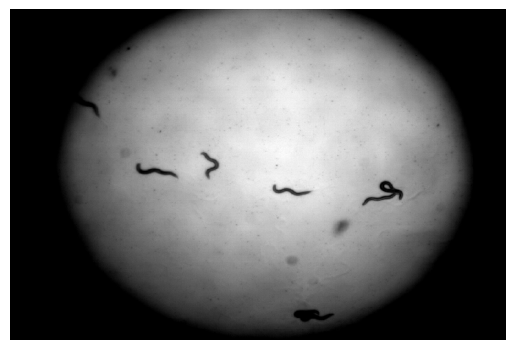

In [20]:
video_path = "../../drive/MyDrive/video/ILG6_2x.avi"

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Unable to open the video file!")

_, frame0 = cap.read()

img = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gist_gray')
plt.axis("off")
plt.show()

## Pretrained model weights
The following cell will download the weights for the models trained in the [original publication](https://www.nature.com/articles/s41598-025-93533-0) into folder `weights` in `WormYOLO`. Other weights can be added here. The different datasets used in the publication are described below.

In [8]:
!mkdir -p ./weights/
# BBC010
!gdown https://drive.google.com/uc?id=1FLI5OKKHDSGvHFiaYw77d-yzlFdlSN7F -O ./weights/bbc010_best.pt
# CSB-1
!gdown https://drive.google.com/uc?id=1W0Hch2aQSUYjvly0Kd3pGjFQPSYLlpM3 -O ./weights/csb-1_best.pt
# mating dataset
!gdown https://drive.google.com/uc?id=1i-o2APD09ElXKpJxr2HJKZ0txX3EBrQV -O ./weights/md_best.pt
# single worm
!gdown https://drive.google.com/uc?id=1wP2_9Dujn8IDr4MUhEWmPBDlHZR_YUer -O ./weights/sw_best.pt
# synthetic dataset
!gdown https://drive.google.com/uc?id=1LK15XYCbjujrGpmWVyOrgIQazmk7Y_KF -O ./weights/synthetic_best.pt

Downloading...
From (original): https://drive.google.com/uc?id=1FLI5OKKHDSGvHFiaYw77d-yzlFdlSN7F
From (redirected): https://drive.google.com/uc?id=1FLI5OKKHDSGvHFiaYw77d-yzlFdlSN7F&confirm=t&uuid=01ad7e0c-9040-428b-a19a-20e75330bd3b
To: /content/WormYOLO-Count/WormYOLO/weights/bbc010_best.pt
100% 40.9M/40.9M [00:00<00:00, 83.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1W0Hch2aQSUYjvly0Kd3pGjFQPSYLlpM3
From (redirected): https://drive.google.com/uc?id=1W0Hch2aQSUYjvly0Kd3pGjFQPSYLlpM3&confirm=t&uuid=5eb87b51-e194-4c31-b7e5-c17e3c3e4f29
To: /content/WormYOLO-Count/WormYOLO/weights/csb-1_best.pt
100% 40.9M/40.9M [00:00<00:00, 240MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1i-o2APD09ElXKpJxr2HJKZ0txX3EBrQV
From (redirected): https://drive.google.com/uc?id=1i-o2APD09ElXKpJxr2HJKZ0txX3EBrQV&confirm=t&uuid=cb2e8105-20e4-46c7-b1ad-5f3892e36131
To: /content/WormYOLO-Count/WormYOLO/weights/md_best.pt
100% 122M/122M [00:01<00:00, 113MB/s]
Downloa

## Test a model on one frame
Choose one of the models below. Every model has been trained on a different data set. They perform the best, if the training data is similar to data in your project. Here is a short summary of train data used for the different choices:
* bbc010_best: images containing multiple worms, 256 x 256 pixels centered on one worm.
* csb-1_best: videos with multiple worms, 5 Hz, 912 x 736 pixels.
* md_best: video with multiple worms, downsampled to 5 Hz, 1012 x 1012 pixels.
* sw_best: images of single worms, 1496 x 1500 pixels.
* synthetic_best: images, derived from CSB-1, 912 x 736 pixels.


In [9]:
# choose model: bbc010_best, csb-1_best, md_best, sw_best, synthetic_best
model = YOLO("./weights/synthetic_best.pt")


0: 640x928 3 worms, 86.2ms
Speed: 13.5ms preprocess, 86.2ms inference, 194.3ms postprocess per image at shape (1, 3, 640, 928)


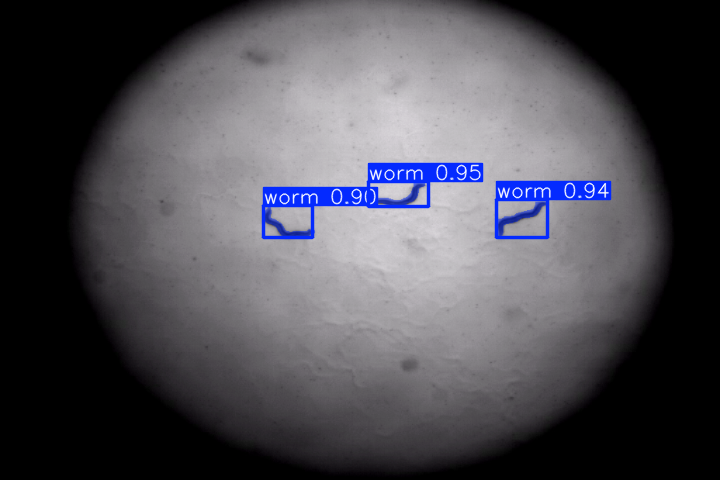

In [10]:
# adjust the 'confidence', to remove false positive results
confidence = 0.4
frame_nr = 2

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
success, frame = cap.read()

results = model(frame, conf=confidence)
results[0].show()

## Create output files and folders
By default, the results are saved in a sub-folder of "track_result" in the folder, where the original video file is, with the same name as the video. If there are already results for that video, they will be overwritten.

In [21]:
# create output folder
video_filename = os.path.splitext(os.path.basename(video_path))[0]
main_output_dir = os.path.join("../../drive/MyDrive/video", video_filename)
os.makedirs(main_output_dir, exist_ok=True)

# create result files
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Reset video capture to the beginning
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video properties: FPS={fps}, Width={width}, Height={height}")

all_masks_path = os.path.join(main_output_dir, "track_video.avi")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
all_masks_writer = cv2.VideoWriter(all_masks_path, fourcc, fps, (width, height))

txt_file_path = os.path.join(main_output_dir, "track_boxes.txt")
with open(txt_file_path, "w") as f:
    f.write("")

Video properties: FPS=25.0, Width=720, Height=480


## Run segmentation and tracking
The segmentation is run on the whole video. Results are saved as `results.pk` for further analysis in python and as mask images for using feature point extraction and counting (see [WormYOLO-Count repository](https://github.com/1490560350/WormYOLO-Count)).

In [22]:
frame_count = 2
track_id_colors = {}
frame_skip = 1
video_segments = {}

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_count += 1

    if frame_count % frame_skip != 0:
        continue

    try:
        # object tracking
        results = model.track(frame, persist=True, conf=confidence)
        # Retrieve the detected boxes and their corresponding tracking IDs
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()  # Obtain the coordinates of the top-left and bottom-right corners
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Obtain mask coordinates
            masks = results[0].masks.xy

            # Create a dictionary with track_id as the key and the corresponding mask as the value
            mask_dict = defaultdict(list)
            if masks is not None:
                for mask, track_id in zip(masks, track_ids):
                    mask_dict[track_id].append(mask)

            video_segments[frame_count-1] = mask_dict

            # Iterate through all track_id values and output the masked image
            for track_id in mask_dict:
                track_output_dir = os.path.join(main_output_dir, f"id{track_id}_image")
                os.makedirs(track_output_dir, exist_ok=True)

                mask_frame = np.ones((height, width, 3), dtype=np.uint8) * 255

                for idx, mask in enumerate(mask_dict[track_id]):
                    mask_points = mask.reshape((-1, 1, 2)).astype(np.int32)
                    if mask_points.size == 0:
                        print(f"No mask for track ID {track_id} found in frame {frame_count}.")
                        continue
                    cv2.fillPoly(mask_frame, [mask_points], (0, 0, 0))  # 黑色

                    output_image_path = os.path.join(track_output_dir, f"{frame_count-1}.png")
                    cv2.imwrite(output_image_path, mask_frame)

        else:
            print(f"No worms found in frame {frame_count-1}.")
            continue

        # Draw detection boxes, IDs and masks on the original frame
        all_masks_frame = frame.copy()

        if masks is not None:
            for bbox, track_id, mask in zip(boxes, track_ids, masks):
                if track_id not in track_id_colors:
                    track_id_colors[track_id] = generate_random_color()

                color = track_id_colors[track_id]
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(all_masks_frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(all_masks_frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                mask_points = mask.reshape((-1, 1, 2)).astype(np.int32)
                if mask_points.size == 0:
                    print(f"No mask for track ID {track_id} found in frame {frame_count}.")
                    continue
                single_mask = np.zeros((height, width), dtype=np.uint8)
                cv2.fillPoly(single_mask, [mask_points], 255)
                color_mask = np.zeros_like(frame)
                color_mask[:, :] = color
                colored_mask = cv2.bitwise_and(color_mask, color_mask, mask=single_mask)
                all_masks_frame = cv2.addWeighted(all_masks_frame, 1.0, colored_mask, 0.2, 0)

                with open(txt_file_path, "a") as f:
                    f.write(f"{frame_count-1},{track_id},{x1-3},{y1+3},{x2 - x1+3},{y2 - y1+3},-1,-1,-1\n")

        all_masks_writer.write(all_masks_frame)

    except Exception as e:
        print(f"An error occurred during processing of frame {frame_count}: {e}")
        continue

cap.release()
all_masks_writer.release()
with open(os.path.join(main_output_dir,'result.pk'), 'wb') as f:
    pickle.dump(video_segments, f)

print(f"The tracking results have been saved to the {main_output_dir} directory.")


0: 640x928 1 worm, 88.6ms
Speed: 4.9ms preprocess, 88.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 81.5ms
Speed: 7.2ms preprocess, 81.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 77.4ms
Speed: 4.1ms preprocess, 77.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 68.8ms
Speed: 4.3ms preprocess, 68.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 57.9ms
Speed: 3.7ms preprocess, 57.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 53.8ms
Speed: 4.5ms preprocess, 53.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 53.6ms
Speed: 4.3ms preprocess, 53.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)

0: 640x928 3 worms, 53.2ms
Speed: 4.1ms preprocess, 53.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)

